In [136]:
import matplotlib.pyplot as plt
import imageio.v3 as iio
import numpy as np
import math
from xxhash import xxh32
import cv2

In [137]:
path = 'images/'

lena = cv2.imread(path+'lena_Gray.tiff', cv2.IMREAD_GRAYSCALE)

In [138]:
def im2blk(img, r, c):
    R, C = img.shape[0:2]//np.array([r, c])
    if img.ndim == 2:
        return img.reshape(R, r, C, c).swapaxes(1, 2)
    else:
        return img.reshape(R, r, C, c, -1).swapaxes(1, 2)

In [139]:
# 測試用func
def get_PSNR(p1, p2):
    MSE = np.sum((p1-p2)**2)/(p1.shape[0]*p1.shape[1])
    return 10 * math.log10(255**2/MSE)

def img_replace(p1, p2, r, c, ratio=1):
    t2 = cv2.resize(p2, None, fx=ratio, fy=ratio)
    t1 = p1.copy()
    t1[r:r+t2.shape[0], c:c+t2.shape[1]] = np.where(t2 != 0, t2, p1[r:r+t2.shape[0], c:c+t2.shape[1]])
    return t1

In [140]:
# 公式3
def get_ll(block2x2):
    row_ll = []
    for row in block2x2:
        s0, s1 = row[0], row[1]
        d = s1 - s0
        s = s0 + (d//2)
        row_ll.append(s)
    s0, s1 = row_ll[0], row_ll[1]
    d = s1 - s0
    ll = s0 + d//2
    return ll
def get_haar_4x4(block4x4):
    temp = np.zeros((4, 4), dtype=int)
    for r in range(4):
        d1 = block4x4[r, 1] - block4x4[r, 0]
        s1 = block4x4[r, 0] + (d1 // 2)
        d2 = block4x4[r, 3] - block4x4[r, 2]
        s2 = block4x4[r, 2] + (d2 // 2)
        temp[r, 0], temp[r, 1], temp[r, 2], temp[r, 3] = s1, s2, d1, d2
    coeffs = np.zeros((4, 4), dtype=int)
    for c in range(4):
        dv1 = temp[1, c] - temp[0, c]
        sv1 = temp[0, c] + (dv1 // 2)
        dv2 = temp[3, c] - temp[2, c]
        sv2 = temp[2, c] + (dv2 // 2)
        coeffs[0, c], coeffs[1, c], coeffs[2, c], coeffs[3, c] = sv1, sv2, dv1, dv2
    return coeffs

In [141]:
# 公式5
def arnold_cat_map(x, y, N, i): # i為迭代次數
    for _ in range(i):
        x, y = (x+y) % N, (x+2*y) % N
    return x, y

In [142]:
# 前4位元驗證資料
def generate_auth(block4x4):
    b = (block4x4//4).astype(int).flatten()
    # 圖6
    block2x2 = [
        b[0:4].reshape(2, 2),
        b[4:8].reshape(2, 2),
        b[8:12].reshape(2, 2),
        b[12:16].reshape(2, 2)
    ]

    # 驗證資料4位元
    W = []
    for i in range(4):
        ll = get_ll(block2x2[i])
        # 公式6
        pix = block2x2[i].flatten()
        ir = 0
        for p in pix:
            diff = p-ll
            diff_7bit = diff & 0x7F
            ir ^= diff_7bit

        cnt_1 = bin(ir).count('1')
        W.append(cnt_1%2)
    return W

# 修復資料28位元
def generate_recovery(block4x4):
    b = (block4x4//8).astype(int)
    coeffs = get_haar_4x4(b)
    ll = coeffs[0:2, 0:2].flatten()
    lh = coeffs[0:2, 2:4].flatten()
    hl = coeffs[2:4, 0:2].flatten()

    W = []
    for val in ll:
        for i in range(5):
            bit = (int(val)>>i)%2
            W.append(bit)

    for val in lh:
        W.append(0 if val==0 else 1)

    for val in hl:
        W.append(0 if val==0 else 1)

    return W

# 3.2 生成水印
def generate_watermark(A_block4x4, B_block4x4):
    return generate_auth(B_block4x4) + generate_recovery(A_block4x4)

In [143]:
# 3.3 嵌入水印
def embed_wm(idx, A_block4x4, B_block4x4):
    W = generate_watermark(A_block4x4, B_block4x4)
    w = []
    for i in range(32):
        w.append(((idx>>i)%2)^W[i])

    b = B_block4x4.flatten().astype(int)
    wb = np.zeros(16, dtype=int)

    for i in range(16):
        wb[i] = (b[i]//4)*4 + 2*w[2*i+1] + w[2*i]

    return wb.reshape(4, 4)

In [144]:
r, c = lena.shape

# 切分HA,HB,HC,HD
tmp = lena.copy()
HA = tmp[:r//2, :c//2]
HB = tmp[:r//2, c//2:]
HC = tmp[r//2:, :c//2]
HD = tmp[r//2:, c//2:]

final_parts = {
    'HA': HA.copy(), 'HB': HB.copy(), 
    'HC': HC.copy(), 'HD': HD.copy()
}

part_names = ['HA', 'HB', 'HC', 'HD']

seed = 1111
np.random.seed(seed)
parts = np.array([HA, HB, HC, HD])
part_map = np.random.permutation(part_names)
i_list = [23, 23, 23, 23] # 各區域迭代次數

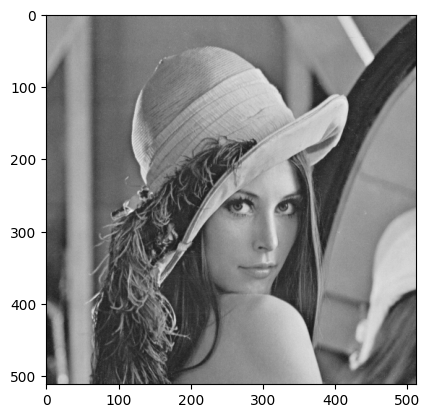

In [145]:
# 3.1
part_n = r//2
block_n = part_n//4
part_coeffs = {'HA': (0,0), 'HB': (0,part_n//4), 'HC': (part_n//4,0), 'HD': (part_n//4,part_n//4)}

# 轉換表
map_table = {
    'HA': {},
    'HB': {},
    'HC': {},
    'HD': {}
}
reverse_map = {
    'HA': {},
    'HB': {},
    'HC': {},
    'HD': {}
}
global_map = {}
idx_map_for_extraction = {name: {} for name in part_names}
global_idx_map = {}

for idx, name in enumerate(part_names):
    k = i_list[idx]
    block_idx = 0
    for x in range(block_n):
        for y in range(block_n):
            nx, ny = arnold_cat_map(x, y, block_n, k)
            px, py = 4*x, 4*y
            
            map_table[name][(x, y)] = (nx, ny)
            reverse_map[part_map[idx]][(nx, ny)] = (x, y)
            pc, nc = part_coeffs[name], part_coeffs[part_map[idx]]
            global_map[(x+pc[0], y+pc[1])] = (nx+nc[0], ny+nc[1])
            idx_map_for_extraction[name][(nx, ny)] = block_idx
            global_idx_map[(nx+nc[0], ny+nc[1])] = block_idx

            nx, ny = 4*nx, 4*ny

            final_parts[part_map[idx]][nx:nx+4, ny:ny+4] = embed_wm(
                block_idx,
                parts[idx][px:px+4, py:py+4],
                final_parts[part_map[idx]][nx:nx+4, ny:ny+4]
                )
            block_idx += 1

global_rev_map = {v:k for k, v in global_map.items()}

lena2 = np.block([
    [final_parts['HA'], final_parts['HB']],
    [final_parts['HC'], final_parts['HD']]
])

plt.imshow(lena2, cmap = 'gray', vmin=0, vmax=255)

In [146]:
# 3.4 提取水印
def extract_wm(block4x4, idx):
    b = block4x4.flatten().astype(int)
    w = np.zeros(32, dtype=int)
    
    for i in range(16):
        w[2*i] = b[i] % 2
        w[2*i+1] = (b[i] >> 1) % 2

    a, r = [], []
    for i in range(32):
        idx_bit = (idx >> i) % 2
        decoded_bit = w[i] ^ idx_bit
        if i < 4:
            a.append(decoded_bit)
        else:
            r.append(decoded_bit)

    return a, r

# lv1偵測
def lv1_detection(part_name, test_part, block_n):
    valid = np.ones((block_n, block_n), dtype=bool)
    
    for bx in range(block_n):
        for by in range(block_n):
            idx = idx_map_for_extraction[part_name][(bx, by)]
            x, y = bx*4, by*4
            block = test_part[x:x+4, y:y+4]

            a, _ = extract_wm(block, idx)
            a2 = generate_auth(block)

            mismatch = sum(1 for i in range(4) if a[i] != a2[i])
            if mismatch > 2:
                valid[bx][by] = False
    return  valid

# lv2偵測
def lv2_detection(parts, valid, block_n):
    lv2_valid = valid.copy()

    for p_name in part_names:
        v = valid[p_name]
        for bx in range(block_n):
            for by in range(block_n):
                reverse_part = part_names[np.where(part_map ==p_name)[0][0]]
                ax, ay = reverse_map[p_name][bx, by]
                if valid[reverse_part][ax, ay]:
                    x_st, x_en = max(0, bx-1), min(block_n, bx+2)
                    y_st, y_en = max(0, by-1), min(block_n, by+2)
                    neighbor = v[x_st:x_en, y_st:y_en]

                    if not np.all(neighbor):
                        idx = idx_map_for_extraction[p_name][bx, by]
                        px, py = bx*4, by*4
                        apx, apy = ax*4, ay*4

                        _, r = extract_wm(parts[p_name][px:px+4, py:py+4], idx)
                        r2 = generate_recovery(parts[reverse_part][apx:apx+4, apy:apy+4])

                        if r != r2:
                            lv2_valid[p_name][bx][by] = False

    return lv2_valid

# lv3偵測
def lv3_detection(valid):
    lv3_valid = valid.copy()
    bn  = valid.shape[0]

    for x in range(1, bn-1):
        for y in range(1, bn-1):
            if valid[x, y]:
                neighbor = valid[x-1:x+2, y-1:y+2]
                if np.sum(neighbor) <= 5:
                    lv3_valid[x, y] = False
    
    return lv3_valid

In [147]:
# 3.5修復

# 用28位元的修復資料還原區塊
def recover_block(r_bits):
    # 取4個子區塊的LL(每個5bits)
    ll_coeffs = []
    for i in range(4):
        bits = r_bits[i*5:i*5+5]
        val = 0
        # for b in bits[::-1]:
        #     val = (val << 1) | b
        for power, bit in enumerate(bits):
            val += int(bit) * (2**power)
        ll_coeffs.append(val * 8)

    # 取 LH, HL
    tags = r_bits[20:28]
    recover_pxl = np.zeros((4, 4), dtype=np.uint8)
    sub_croods = [(0,0), (0,2), (2,0), (2,2)]
    for i in range(4):
        # ll = ll_coeffs[i]
        ll = np.clip(ll_coeffs[i], 0, 255).astype(np.uint8)
        lh_tag = tags[i*2]
        hl_tag = tags[i*2+1]
        sub_block = np.full((2, 2), ll, dtype=int)
        r, c = sub_croods[i]
        recover_pxl[r:r+2, c:c+2] = np.clip(sub_block, 0, 255)

    return recover_pxl

# 取 3x3 valid區塊的平均像素值
def get_neighborhood_avg(img, valid, x, y):
    sum = 0
    valid_cnt = 0

    for nx in range(x-1, x+2):
        for ny in range(y-1, y+2):
            if 0 <= nx < 128 and 0 <= ny < 128:
                if valid[nx, ny]:
                    neighbor = img[nx*4:nx*4+4, ny*4:ny*4+4]
                    sum += np.mean(neighbor)
                    valid_cnt += 1
                
    if valid_cnt > 0:
        avg = sum / valid_cnt
    else:
        avg = 128

    return np.full((4, 4), avg)

# 兩級修復
def self_reccovery(img, valid):
    recovered_img = img.copy()
    
    for vax in range(128):
        for vay in range(128):
            if not valid[vax, vay]:
                vbx, vby = global_map[(vax, vay)]
                if valid[vbx, vby]:
                    bx, by = vbx*4, vby*4
                    block_B = img[bx:bx+4, by:by+4]
                    idx = global_idx_map[(vbx, vby)]
                    _, r = extract_wm(block_B, idx)

                    ax, ay = vax*4, vay*4
                    recovered_img[ax:ax+4, ay:ay+4] = recover_block(r)
                else:
                    avg_block = get_neighborhood_avg(img, valid, vax, vay)
                    ax, ay = vax*4, vay*4
                    recovered_img[ax:ax+4, ay:ay+4] = avg_block

    return recovered_img

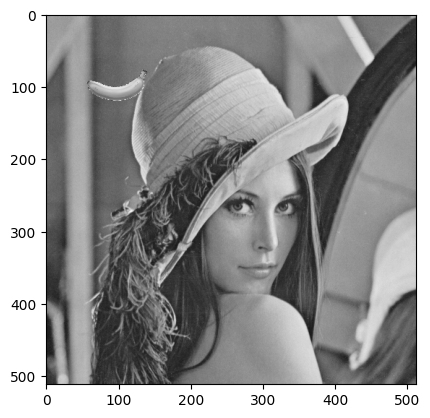

In [148]:
banana = cv2.imread(path+'banana_Gray.png', cv2.IMREAD_GRAYSCALE)
lena_banana = img_replace(lena2, banana, 50, 50, 0.1)
plt.imshow(lena_banana, cmap = 'gray', vmin=0, vmax=255)

In [149]:
tmp = lena_banana.copy()
HA = tmp[:r//2, :c//2]
HB = tmp[:r//2, c//2:]
HC = tmp[r//2:, :c//2]
HD = tmp[r//2:, c//2:]
lst = [HA, HB, HC, HD]
lv1_HA = lv1_detection('HA', HA, block_n)
lv1_HB = lv1_detection('HB', HB, block_n)
lv1_HC = lv1_detection('HC', HC, block_n)
lv1_HD = lv1_detection('HD', HD, block_n)
lv1_valids = {
    'HA': lv1_HA,
    'HB': lv1_HB,
    'HC': lv1_HC,
    'HD': lv1_HD
}

lv1_mask = np.block([
    [lv1_HA, lv1_HB],
    [lv1_HC, lv1_HD]
])

In [150]:
lv2_valids = lv2_detection(final_parts, lv1_valids, block_n)

lv2_mask = np.block([
    [lv2_valids['HA'], lv2_valids['HB']],
    [lv2_valids['HC'], lv2_valids['HD']]
])

In [151]:
valid = lv3_detection(lv2_mask)

np.where(valid==False)

(array([19, 20, 22, 22, 23, 23, 24, 24, 25, 25, 25, 25, 25, 25, 26, 26, 26,
        26, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 29,
        29, 29]),
 array([33, 34, 30, 33, 29, 30, 29, 30, 17, 19, 22, 23, 30, 33, 25, 26, 27,
        32, 18, 22, 26, 27, 28, 29, 31, 17, 21, 22, 23, 25, 27, 28, 30, 22,
        23, 26]))

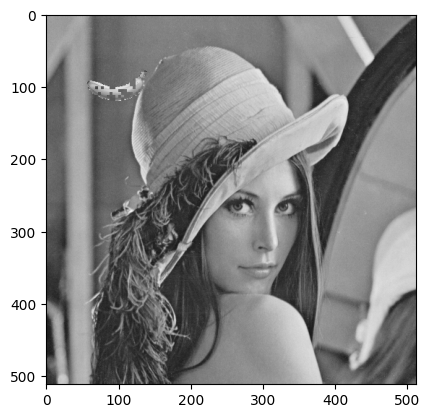

In [ ]:
recovered_img = self_reccovery(lena_banana, valid)

plt.imshow(recovered_img, cmap = 'gray', vmin=0, vmax=255)